# Code from https://medium.com/latinxinai/is-it-an-animal-or-anime-character-e7cec4d99a48

In [2]:
import tensorflow as tf

version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

m = keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2", trainable=True),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
m.build([None, 128, 128, 3])

In [4]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 32)                32064     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1724586 (6.58 MB)
Trainable params: 1710506 (6.53 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [15]:
X_train

,clean_title
81,tapir nose and teeth
915,men women want sex at opposite times of day
1018,available here
380,cristiano ronaldiver
1029,new zealand breast care nurse collects and del...
...,...
1130,train to be a nurses aide wwii recruiting poster
1294,sfw
860,dude on the far left
1459,a dog in a colorful room


In [6]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load('images_processed.npy')

In [8]:
import pandas as pd

image_names = pd.read_csv('image_names.csv')
image_names['name'] = image_names['name'].str.extract(r'(\d+)').astype(int) - 1
image_names

,name
0,1501
1,810
2,1263
3,1269
4,804
...,...
1386,1254
1387,1240
1388,1526
1389,1268


In [9]:
subsample = pd.read_csv('subsample.tsv', sep='\t')
subsample_with_img = subsample.iloc[image_names['name']]

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = images
y = subsample_with_img[['2_way_label']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [11]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = m.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.05)

Epoch 1/5
28/28 [==============================] - 30s 121ms/step - loss: 1.0126 - accuracy: 0.5362 - val_loss: 0.7777 - val_accuracy: 0.5106
Epoch 2/5
28/28 [==============================] - 1s 36ms/step - loss: 0.7548 - accuracy: 0.5995 - val_loss: 0.7430 - val_accuracy: 0.6383
Epoch 3/5
28/28 [==============================] - 1s 43ms/step - loss: 0.6706 - accuracy: 0.6787 - val_loss: 0.8702 - val_accuracy: 0.6170
Epoch 4/5
28/28 [==============================] - 1s 49ms/step - loss: 0.5670 - accuracy: 0.7760 - val_loss: 0.7711 - val_accuracy: 0.6383
Epoch 5/5
28/28 [==============================] - 1s 33ms/step - loss: 0.4754 - accuracy: 0.8371 - val_loss: 1.5844 - val_accuracy: 0.6809


In [13]:
m.evaluate(X_test, y_test)

15/15 [==============================] - 1s 43ms/step - loss: 2.4153 - accuracy: 0.5543


[2.415342330932617, 0.554347813129425]

In [14]:
preds = m.predict(X_test)

15/15 [==============================] - 1s 9ms/step


In [15]:
y_test['image_score'] = preds

In [16]:
y_test

,2_way_label,image_score
942,0,0.985655
180,1,0.992218
1079,0,0.865050
1430,0,0.602334
1171,0,0.999492
...,...,...
1917,0,0.999140
1657,0,0.992870
1442,1,0.872285
803,1,0.999998


<Axes: title={'center': 'image_score'}, xlabel='2_way_label'>

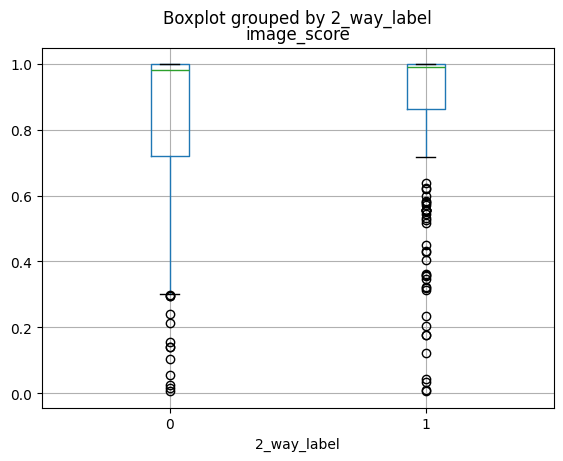

In [17]:
y_test.boxplot(column='image_score', by='2_way_label')

<Axes: >

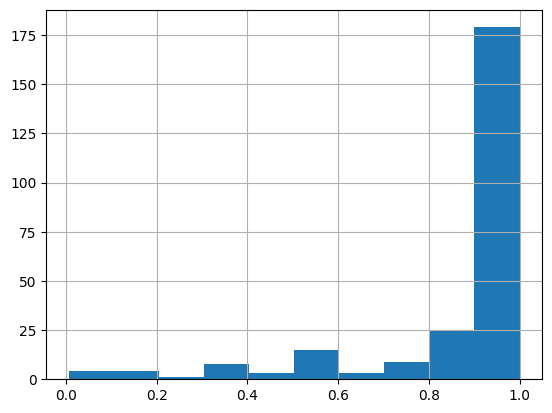

In [18]:
y_test[y_test['2_way_label'] == 1]['image_score'].hist()

<Axes: >

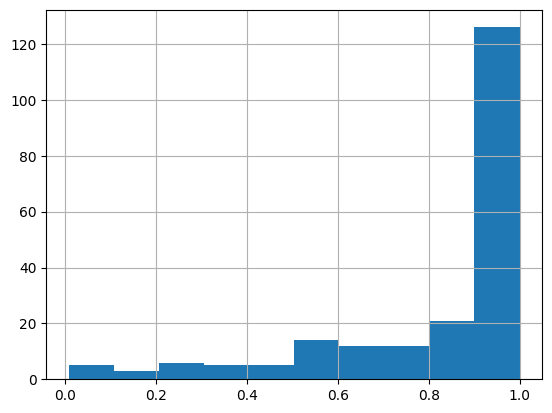

In [19]:
y_test[y_test['2_way_label'] == 0]['image_score'].hist()

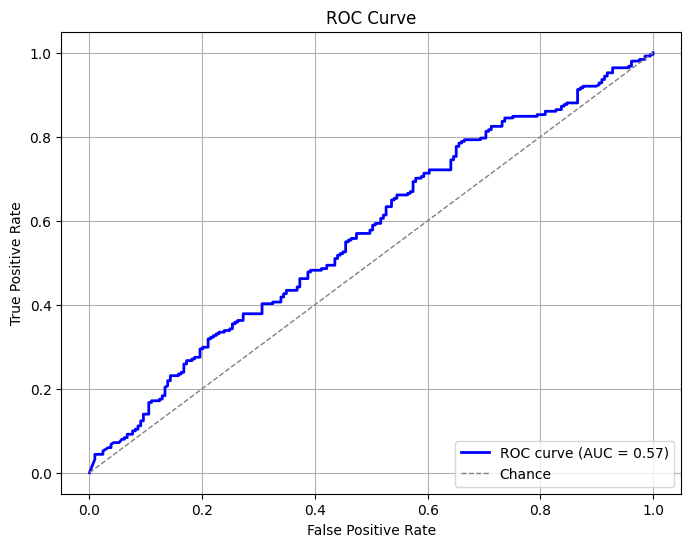

In [20]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

df = y_test

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(df['2_way_label'], df['image_score'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Chance')

# Customize the plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [21]:
y_test.to_csv('image_scores.csv')